# SHAP (Shapley Additive Explanations)

Shap is a method to explain individual predictions, based on the game theoretically optimal Shapley values. Calculating Shapley value to get feature contributions is computationally expensive. There are two methods to approximate SHAP values to improve computation efficiency: KernelSHAP, TreeSHAP (for tree-based models only).

For more information about the method and codes, you can read from [here.](https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea)

In [15]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, ensemble, model_selection
import numpy as np
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import shap
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [16]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,alcohol_use,nuuska,cigarette,e_cigarette,prob_country,prob_resident,risk_of_use,risk_of_try,cannabis_access,...,household_2.0,household_3.0,education_2.0,education_3.0,education_4.0,violence_treat_2.0,violence_treat_3.0,drug_punishment_2.0,drug_punishment_3.0,drug_punishment_4.0
0,0.0,3.0,1.0,1.0,1.0,3.0,2.0,24.0,13.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,3.0,2.0,23.0,17.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,5.0,1.0,2.0,1.0,4.0,3.0,24.0,18.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,7.0,2.0,2.0,1.0,3.0,2.0,22.0,12.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,1.0,1.0,1.0,3.0,2.0,24.0,16.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [17]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.914525
1.0    0.085475
Name: kannabis, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X, y = data.iloc[:, 1:], data.iloc[:, 0]

# resample by adding samples to minority class using SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks


resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_oversamp, Y_over_samp = resample.fit_resample(X, y)



#split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oversamp,
                                                    Y_over_samp,
                                                    test_size=0.3,
                                                    random_state = 10)



print(f"Class counts after resampling {Counter( Y_over_samp)}")



Class counts after resampling Counter({0.0: 2953, 1.0: 2953})


In [19]:
cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(X_train, y_train)

shap.initjs()

## Feature importance

Now, just to get a basic impression of the model, I recommend to view the feature importers and confusion matrix. Just to understand where we stand with the feature importance, I used scikit-learn that computes the impurity decrease within each tree.

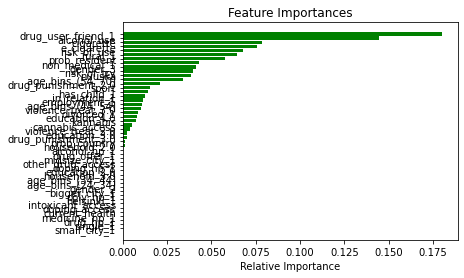

In [20]:
importances = cls.feature_importances_
indices = np.argsort(importances)
features = data.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Confusion matrix

Confusion matrix is a way to visualize the performance of an model. And more important we can easily see were the model fails exactly.

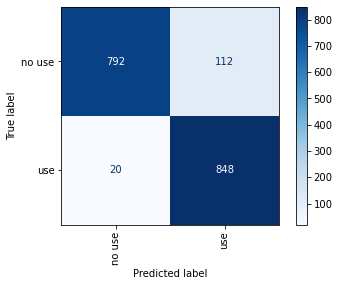

In [21]:
class_names = ['no use', 'use']
disp = plot_confusion_matrix(cls, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

In [22]:
#y.value_counts()
Y_over_samp.value_counts()

0.0    2953
1.0    2953
Name: kannabis, dtype: int64

## SHAP Summary Plot

SHAP values of a model’s output explain how features impact the output of the model.



In [23]:
# compute SHAP values
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X)


Now we can plot relevant plots that will help as analyze the model.


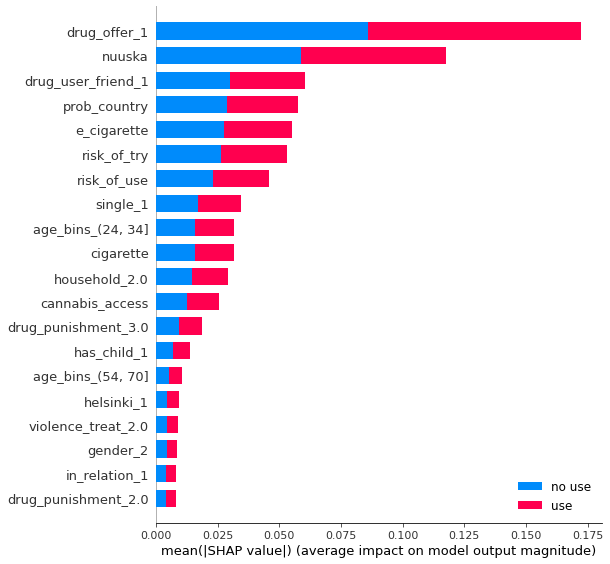

In [24]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)


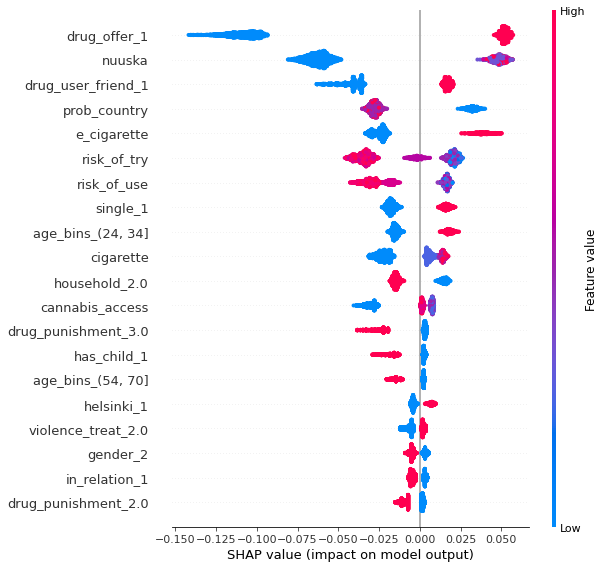

In [25]:
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)


## SHAP Dependence Plot

A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome. An assumption of the PDP is that the first feature are not correlated with the second feature. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible. A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. 

In this example the property value increases significantly when the average number of rooms per dwelling is higher than 6. Each dot is a single prediction (row) from the dataset. The x-axis is the actual value from the dataset. The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

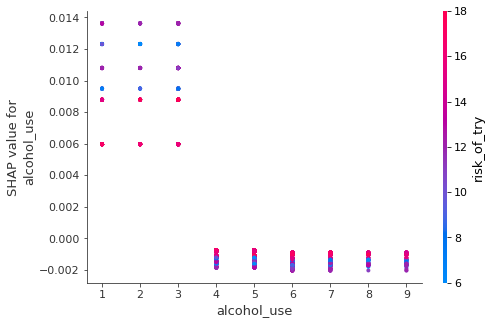

In [26]:
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(0, shap_values[0], X.values, feature_names=X.columns)

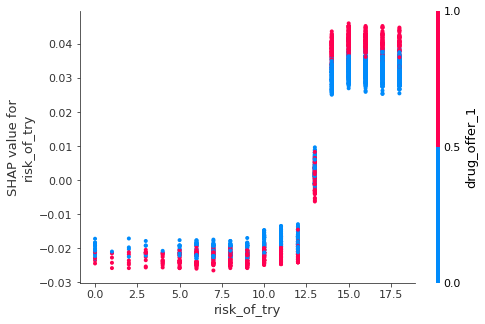

In [44]:
shap.dependence_plot('risk_of_try', shap_values[0], X.values, feature_names=X.columns)

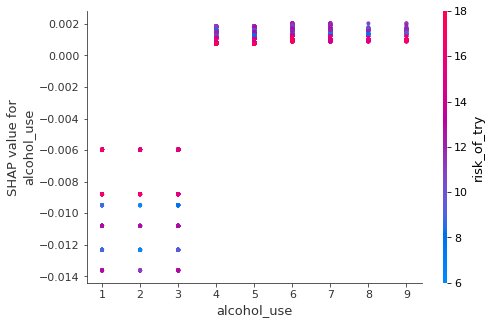

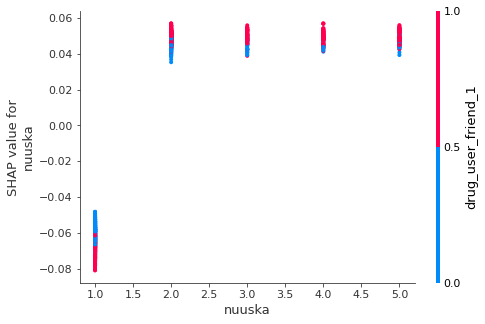

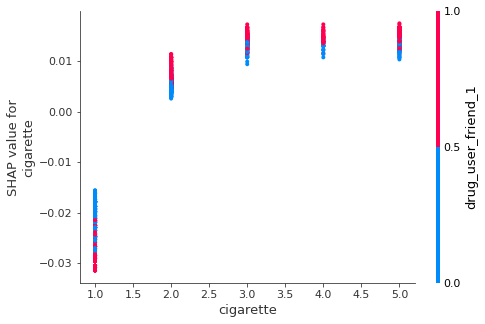

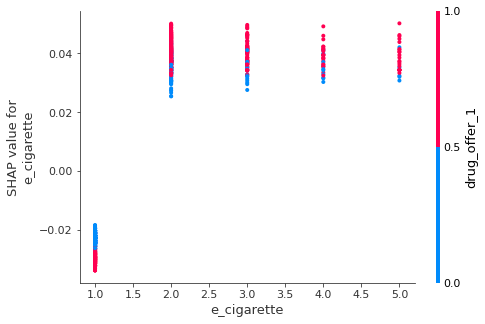

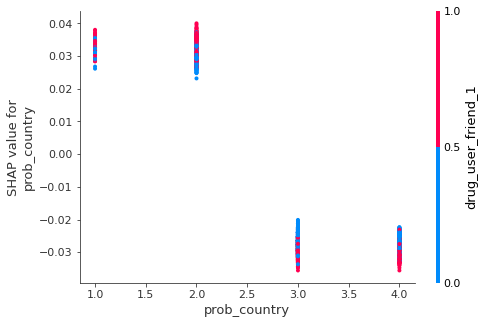

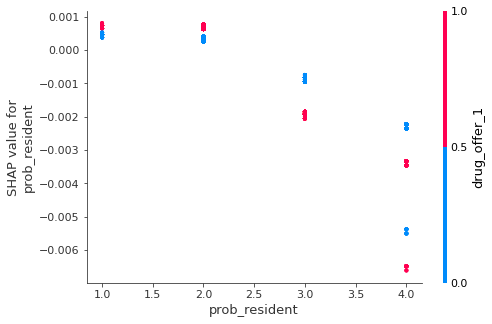

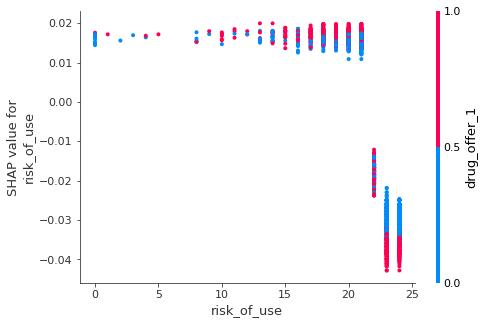

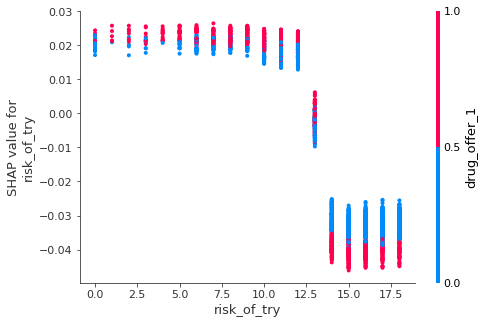

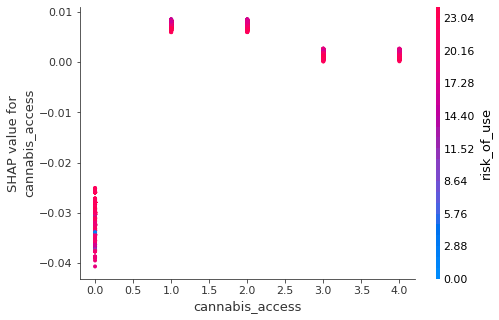

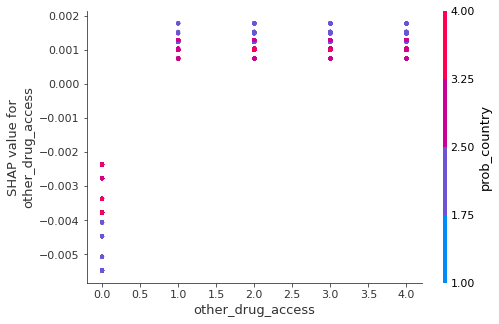

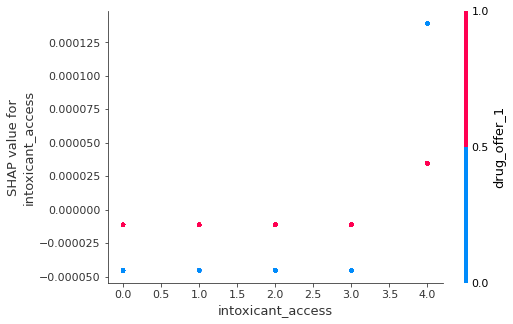

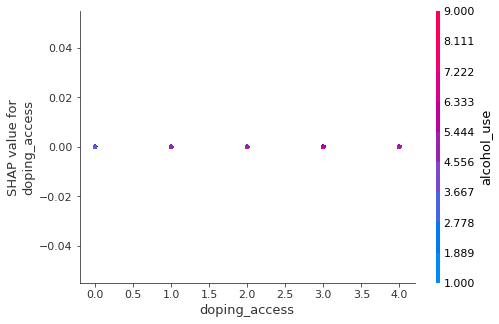

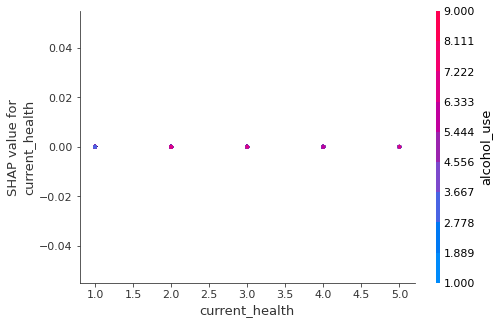

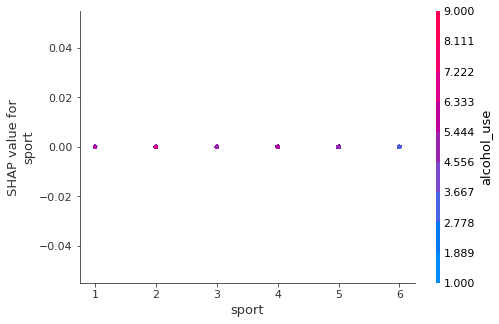

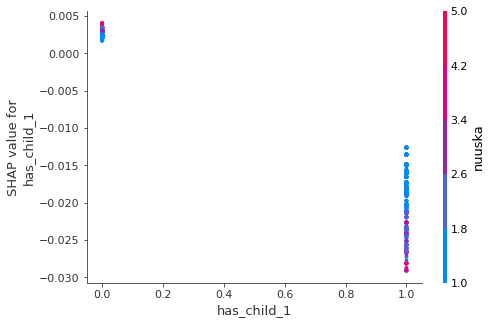

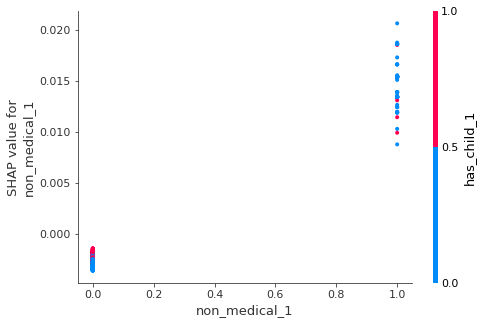

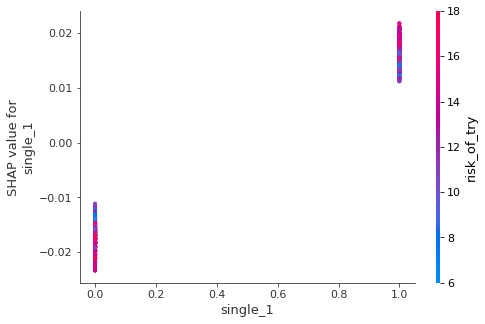

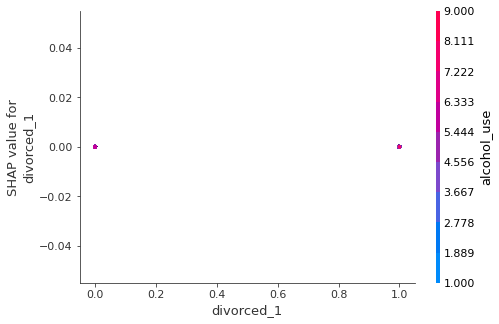

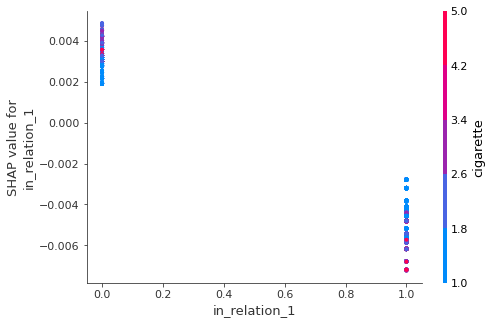

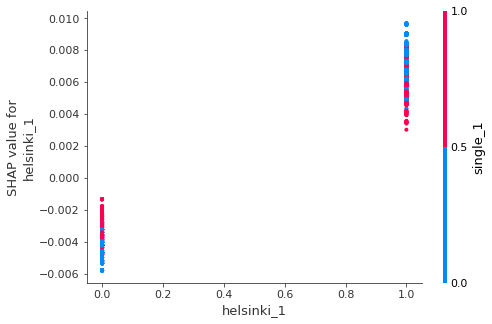

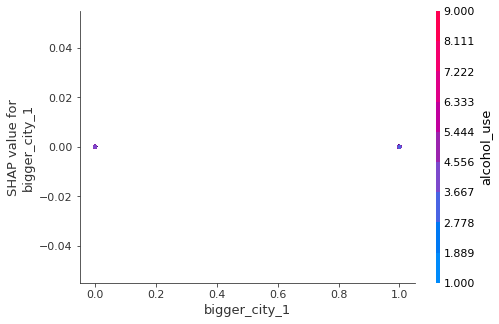

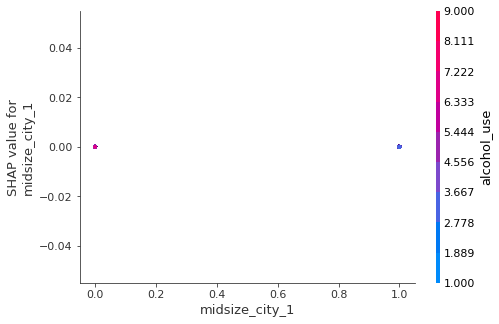

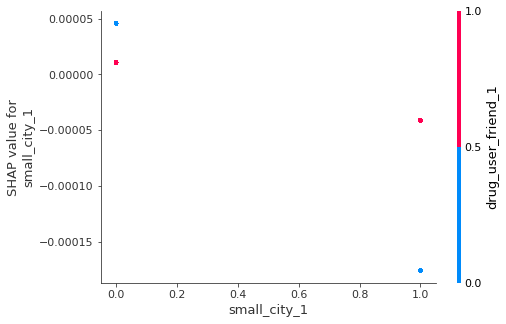

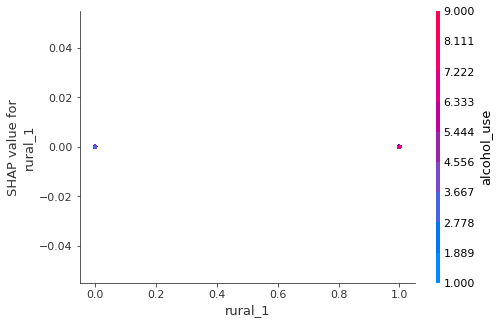

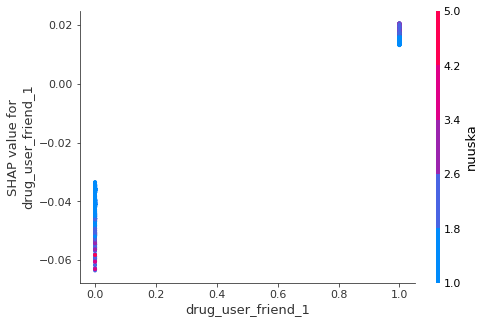

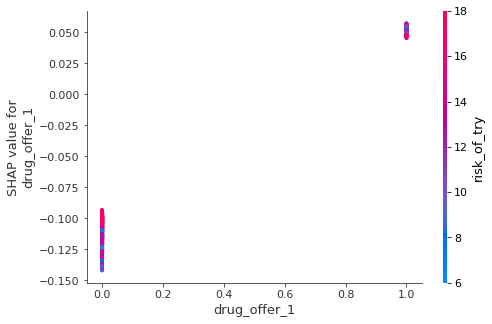

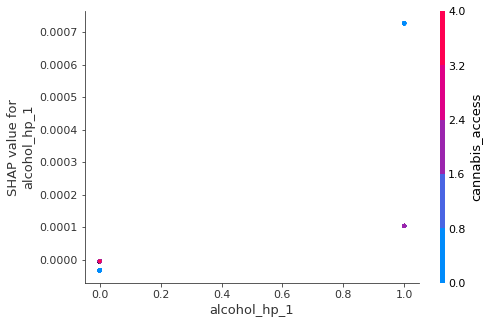

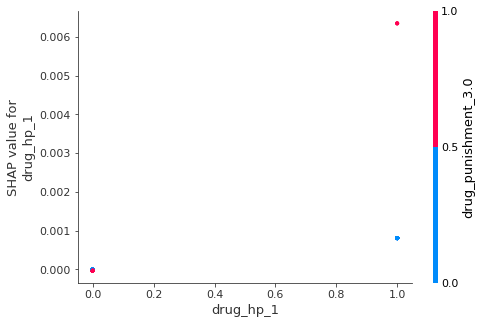

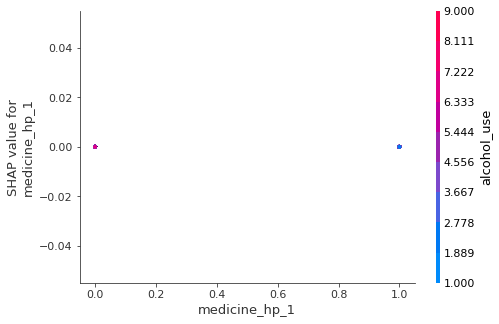

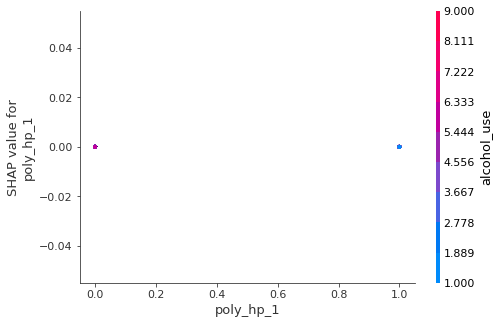

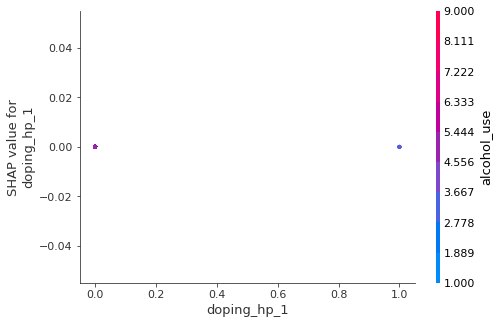

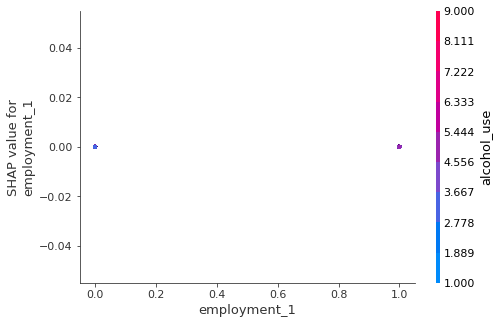

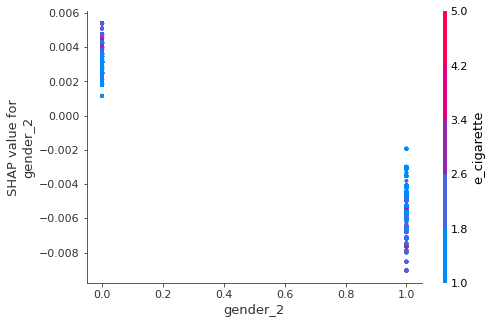

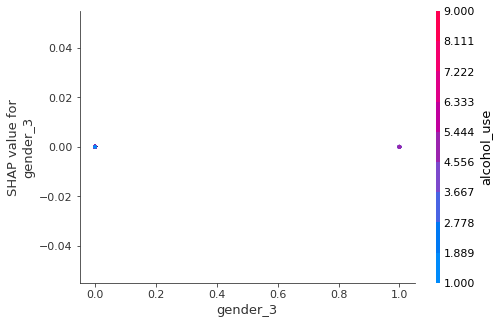

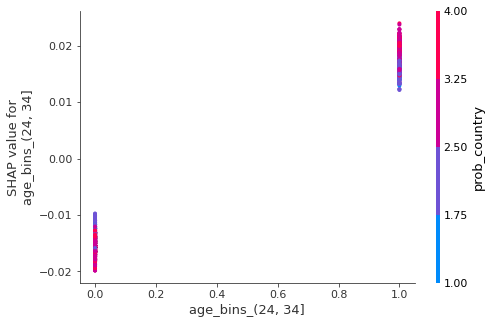

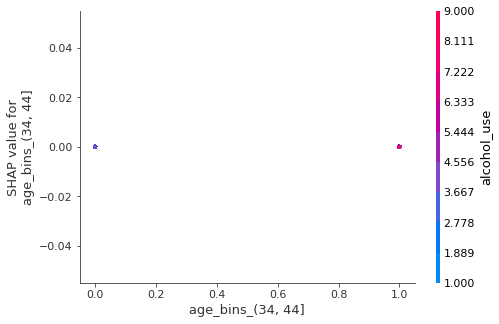

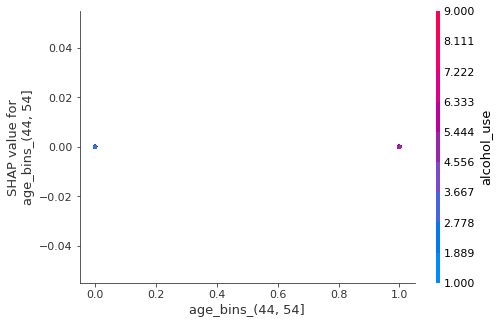

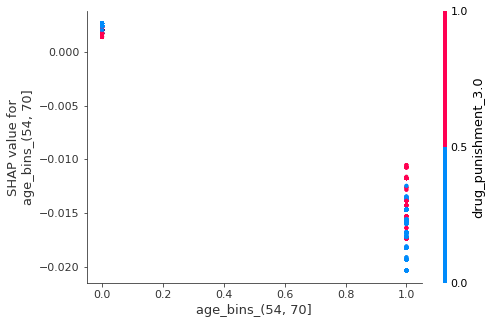

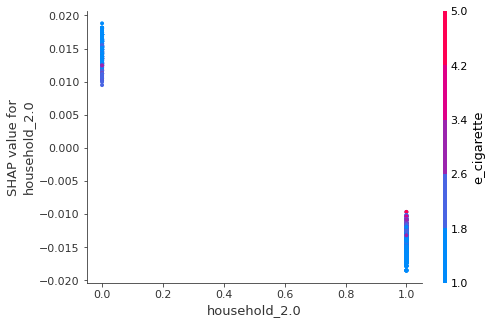

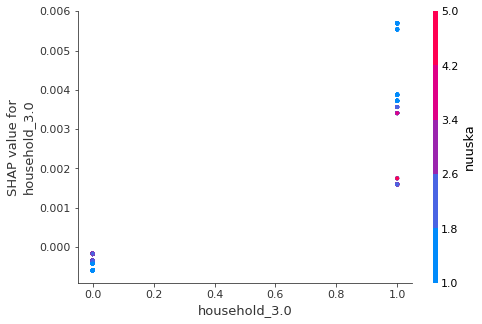

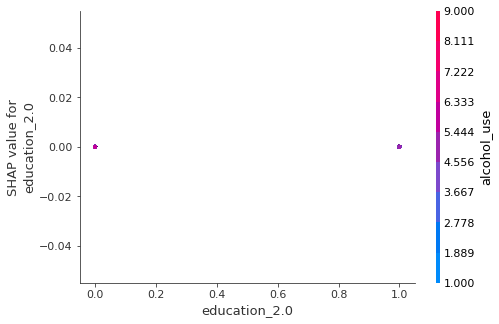

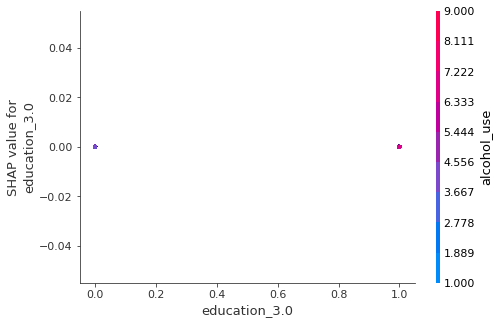

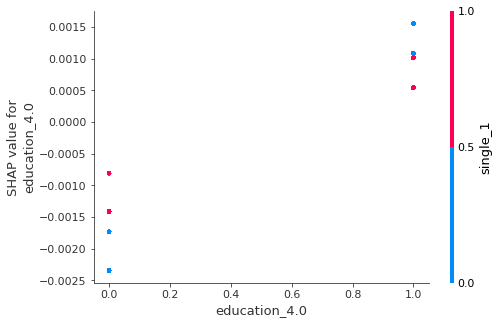

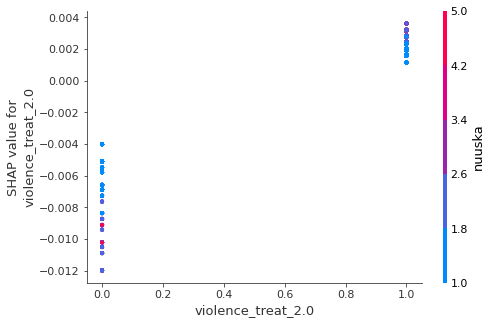

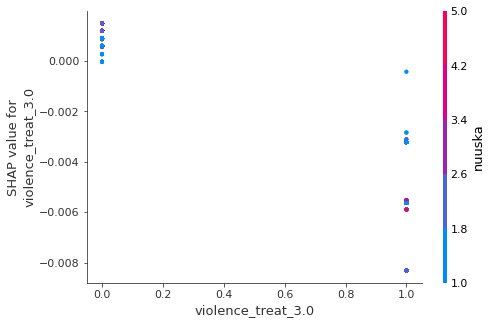

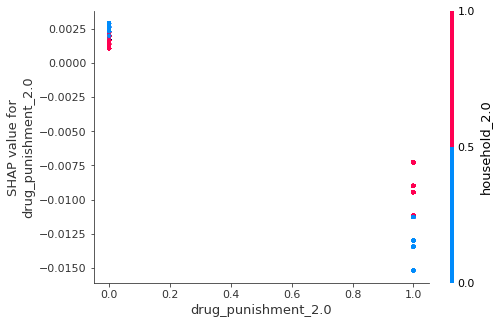

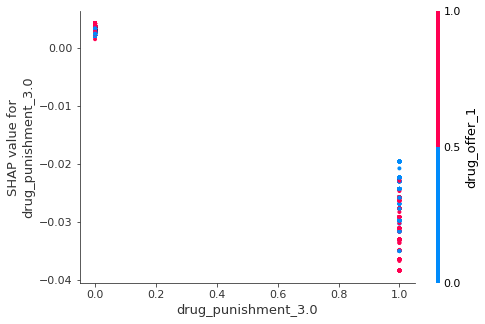

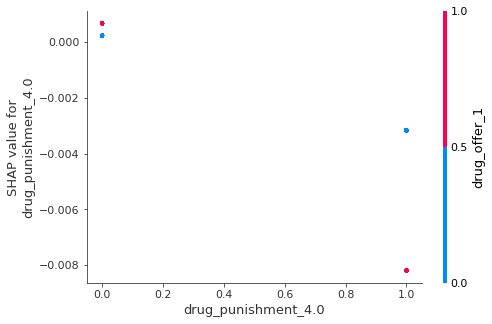

In [40]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X.values, feature_names=X.columns)

## SHAP Force plot

Force plot gives us the explainability of a single model prediction. In this plot, we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or a deep understanding of a particular case.

In [20]:
i=8

shap.force_plot(explainer.expected_value[0], shap_values[0][i], X.values[i], feature_names = X.columns)


From the plot we can see:

- The model predict_proba value: 0.88

- The base value: this is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset (explainer.expected_value in the code). In this example base value = 0.4950

- The numbers on the plot arrows are the value of the feature for this instance. Drug offer and drug user friend

- Red represents features that pushed the model score higher, and blue representing features that pushed the score lower.

- The bigger the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.

- drug offer increases the property that the class is use, drug user friend reduce the property value.

## SHAP waterfall plot

Waterfall is another local analysis plot of a single instance prediction. Let’s take instance number 8 as an example:



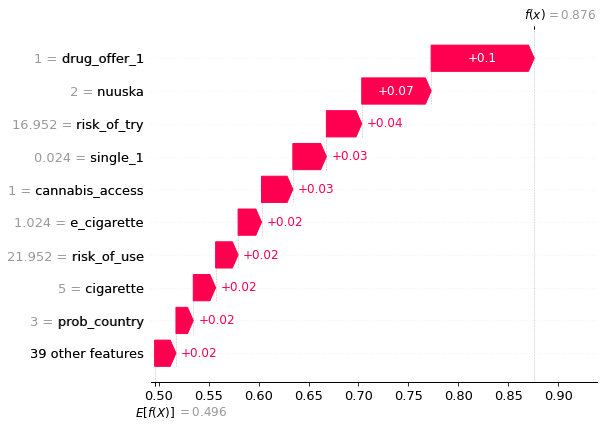

In [25]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                        base_values=explainer.expected_value[0], data=X_test.iloc[row],  
                                        feature_names=X_test.columns.tolist()))

f(x) is the model predict_proba value: 0.875. E[f(x)] is the base value = 0.496. On the left are the features value and on the arrows the feature contribution to the prediction. Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction [2].

## SHAP with Kernel

the SHAP package has explainers for every type of model.

- shap.DeepExplainer works with Deep Learning models.
- shap.KernelExplainer works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.

Here is an example using KernelExplainer to get similar results. The results aren't identical because KernelExplainer gives an approximate result. But the results tell the same story.



In [35]:
# use Kernel SHAP to explain test set predictions
from sklearn.ensemble import RandomForestClassifier
my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [38]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)

array([[0.01, 0.99]])

In [39]:
import shap  # package used to calculate Shap values
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

k_explainer = shap.KernelExplainer(my_model.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Using 4134 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
